In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import collections
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# Read files
df = pd.read_csv("single_cell_lipids.csv", index_col=0)
df2 = df.groupby(lambda x:x, axis=0).sum()

In [ ]:
# Normalize
Xtmp = df2.values[:, :]
Xtmp = Xtmp / Xtmp.sum(0)
most_var_ixs = np.argsort(df2.values.std(1) / df2.values.mean(1))[::-1][:80]
Xtmp = Xtmp[most_var_ixs, :]
Y = Xtmp.T

In [4]:
pca = PCA()
pcs = pca.fit_transform(Y)

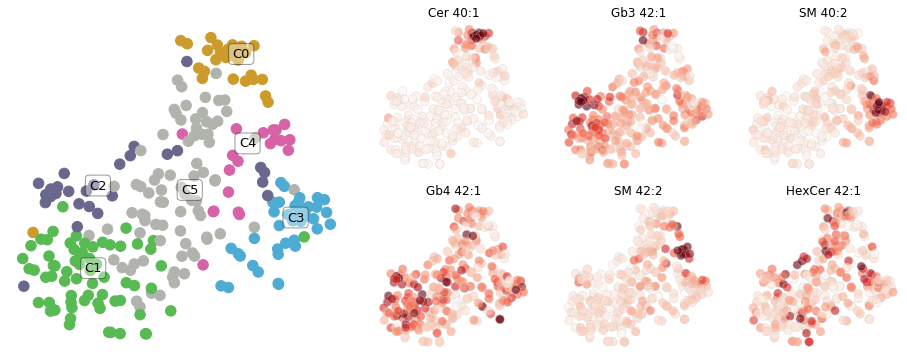

In [5]:
ncomps = 9
nclusts = 6

tsne = TSNE(metric='precomputed', init=pcs[:, :2] / (pcs[:, :2].std(0) / 1e-3), learning_rate= 0.7*pcs.shape[0]/48.,
            perplexity=19, early_exaggeration=15)
np.random.seed(19900715)
D = squareform(pdist(Y, metric="correlation"))**1.5
ts = tsne.fit_transform(D)

plt.figure(None, (16,6))
gs = plt.GridSpec(2,5)
plt.subplot(gs[:, :2])

knn = np.argsort(D, axis=1)[:, 1:1+4]

Zlinkage = linkage(pdist(Y, metric="correlation")**1.5, method="average",optimal_ordering=True)
clusters2 = fcluster(Zlinkage, t=nclusts, criterion="maxclust") - 1 # t=nclusts, criterion="maxclust"

colors_ = np.array([[205,155,43, 255], [87,186,82, 255], [105,103,140,255], [78,172,212,255], [215,99,166,255], [177,179,173,255]])/255
cm = LinearSegmentedColormap.from_list("cluster_cols", colors_)
plt.scatter(ts[:, 0], ts[:, 1], c=clusters2, s=110, cmap=cm, zorder=2)
for i in np.unique(clusters2):
    coords = np.median(ts[clusters2 == i, :], 0)
    plt.text(coords[0],coords[1], f"C{i}", fontdict={"size":13}, bbox=dict(boxstyle='round', facecolor='w', alpha=0.4))
plt.axis("off")


lipids_to_plot = ["Cer 40:1", "Gb3 42:1", 
                  'SM 40:2', "Gb4 42:1", "SM 42:2", "HexCer 42:1", ] # "PC 40:9",'PC 42:10','HexCer 40:1',"Gb3 40:1", "HexCer 42:1", "PE 38:5"


Xtmp2 = df2.values[:, :]
Xtmp2 = Xtmp2 / Xtmp2.sum(0)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[:,2:])
for i, lp in enumerate(lipids_to_plot):
    plt.subplot(gs2[i])
    ith = np.where(df2.index == lp)[0]
    if len(ith) > 1:
        ith = ith[1]
    else:
        ith = ith[0]
    colorandum = Xtmp2[ith, :] # df.iloc[ith, :].values[ixs_cells]
    colorandum = colorandum - np.percentile(colorandum, 2.5)
    colorandum = colorandum / np.percentile(colorandum, 97.5)
    colorandum = np.clip(colorandum, 0, 1)
    plt.scatter(ts[:, 0], ts[:, 1], c=colorandum, s=75, cmap=plt.cm.Reds, alpha=0.6, ec="0.8",lw=0.5)
    plt.title(lp)
    plt.axis("off");

In [6]:
ixs_cells = leaves_list(Zlinkage)
cluster_label = clusters2

most_var_ixs = np.argsort(df.values.std(1) / df.values.mean(1))[::-1][:90]

X = df.values[:, ixs_cells]
cluster_label_sorted = cluster_label[ixs_cells]
Xnorm = X.copy()
Xnorm = Xnorm / Xnorm.sum(0)
Xnorm = Xnorm - np.percentile(Xnorm, 5, axis=1)[:, None]
Xnorm = Xnorm / np.percentile(Xnorm, 95, axis=1)[:, None]
Xnorm = np.clip(Xnorm, 0, 1)
Xnorm = Xnorm[most_var_ixs, :]

In [7]:
Z = np.zeros((Xnorm.shape[0], len(np.unique(cluster_label_sorted))))
for i in np.unique(cluster_label_sorted):
    Z[:, i] = Xnorm[:, cluster_label_sorted == i].mean(1)

In [8]:
Zlinkage_lip = linkage(pdist(Xnorm, metric="correlation"), method="average",optimal_ordering=True)
ixs_lipids = leaves_list(Zlinkage_lip)

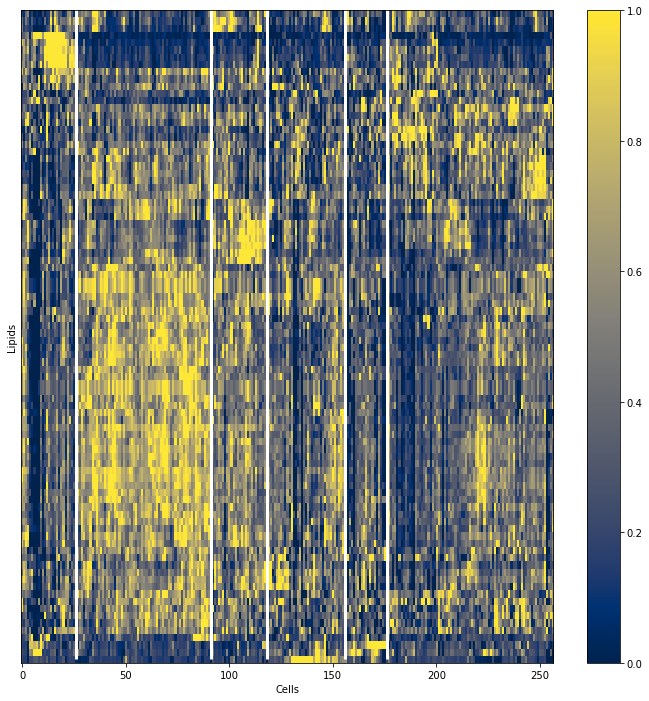

In [9]:
plt.figure(None, (12,12))
plt.imshow(Xnorm[ixs_lipids, :], cmap=plt.cm.cividis, aspect=3.5, interpolation="none")
plt.vlines(np.where(np.diff(cluster_label_sorted))[0], 0, Xnorm.shape[0], color="w", lw=3)
plt.ylim(-0.5, len(ixs_lipids)-0.5)
plt.yticks([])
plt.xlabel("Cells")
plt.ylabel("Lipids")
plt.colorbar()